In [123]:
import numpy as np
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.signal import hilbert, butter, filtfilt

import mne 
from mne.time_frequency import psd_welch

## check no-TACS data 

In [124]:
## import no-tacs data

data, header=  pyxdf.load_xdf('../recordings/P01-no-tacs-R1.xdf')

if data[0]['info']['name'][0] == 'ExperimentMarkers': 
    markers_data = data[0] 
    opm_data = data[1]
else: 
    markers_data = data[1]   
    opm_data = data[0]

fs = 1000 # sampling rate 

opm_time_stamps = opm_data['time_stamps'] 


In [125]:
## set up the markers information
marker_id_start = 7
marker_id_end = 9
marker_id_blink_on = 2
marker_id_blink_off = 1

markers_data_ts = markers_data['time_stamps']

# get the approximate index in chassis time stamp for start trigger
start_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_start)[0]][0]
diff = start_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
start_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]

# get the approximate index in chassis time stamp for end trigger
end_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_end)[0]][0]
diff = end_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
end_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]


In [136]:
## setting up the data for processing 

start = start_marker_index # seconds in 
end = end_marker_index #seocnds before it ends
adc_diode_idx = 0
adc_tacs_idx = 11
opm_data_cut = opm_data['time_series'][start:end, :] * 1e-15 #in tesla

num_channels_w_adcs = opm_data_cut.shape[1]
num_samples = opm_data_cut.shape[0]

adc_diode = opm_data_cut[:, adc_diode_idx]
adc_tacs = opm_data_cut[:, adc_tacs_idx]

opm_data_cut = np.delete(opm_data_cut, adc_tacs_idx, 1)
opm_data_cut = np.delete(opm_data_cut, adc_diode_idx, 1)

# plt.plot(adc_diode)
print("Time left in raw: %f s" %(opm_data_cut.shape[0]/fs))



Time left in raw: 55.239000 s


## Make a time-series for the photo diode data

In [127]:
## checking the flicker timing recorded by the photodiode on the projector

threshold = min(adc_diode) + (max(adc_diode) - min(adc_diode)) * 0.8

adc_diode_square = np.where(adc_diode > threshold, 1, 0) #square signal
adc_diode_markers = np.where(adc_diode > threshold, 1, 0) # vertical lines

on = False

for idx, x in enumerate(adc_diode_square): 
    if x==1 and not on: ## if this is the first one
        on = True
    elif x==1 and on: ## during the on period.
        adc_diode_square[idx] = 1 
        adc_diode_markers[idx] = 0
        if idx+1==adc_diode_square.shape[0] or adc_diode_square[idx+1] == 0: ## if this is the last one
            adc_diode_square[idx] = 1 
            adc_diode_markers[idx] = 1
            on = False

# plt.plot(adc_diode_square[:6000])
# plt.figure()
# plt.plot(adc_diode_markers[:6000])

# get the timing on between flickers. It should be 0.1 s interval (10hz flicker) + random ITI 
index_diode_on = np.where(adc_diode_markers == 1)[0] 
timing_diode = np.diff(time_stamps[index_diode_on])
# plt.figure()
# plt.plot(timing_diode[:100])

## create a phase time series of the ADC diode (visual stimuli)
adc_diode_phase = np.angle(hilbert(adc_diode_square), deg=False)
# print(adc_diode_phase.shape)
# plt.plot(adc_diode_phase[:3000])

In [128]:
# ## see the flickers with the OPM data
# %matplotlib inline

# plt.plot(time_stamps[650:1650], opm_data_cut[650:1650,0])
# for i in index_diode_on[:10]:
#     plt.axvline(x=time_stamps[i], color='red')

# ## make a time-series of the visual stimulus

    

In [129]:
# channel names according to the order of the OPM data without the ADCs
channel_names = np.zeros(shape=[num_channels_w_adcs], dtype='object') 
channel_types = np.zeros(shape=[num_channels_w_adcs], dtype='object')
channel_units = np.zeros(shape=[num_channels_w_adcs], dtype='object')
for i, channel in enumerate(opm_data['info']['desc'][0]['channels'][0]['channel']):
    # print(channel)
    channel_names[i] = channel['label'][0]
    channel_types[i] = channel['type'][0]
    channel_units[i] = channel['unit'][0]

channel_names = np.delete(channel_names, adc_tacs_idx)
channel_names = np.delete(channel_names, adc_diode_idx)

channel_types = np.delete(channel_types, adc_tacs_idx)
channel_types = np.delete(channel_types, adc_diode_idx)



## analyze OPM data

Creating RawArray with float64 data, n_channels=15, n_times=55239
    Range : 0 ... 55238 =      0.000 ...    55.238 secs
Ready.
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


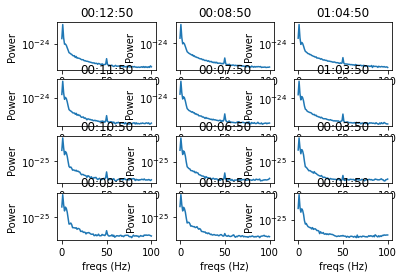

In [130]:
## prepare OPM data struct

%matplotlib inline
info = mne.create_info(list(channel_names), fs, list(channel_types))
raw = mne.io.RawArray(opm_data_cut[:].T, info)
ref_channels = ['01:01:50', '01:02:50', '01:05:50']

channel_orders = ['00:12:50','00:08:50', '01:04:50'
, '00:11:50', '00:07:50', '01:03:50'
, '00:10:50', '00:06:50', '00:03:50'
, '00:09:50', '00:05:50', '00:01:50']


## plot/check reference data
# ref_data = raw.pick_channels(ref_channels)[:][0]
# print(ref_data.shape)
# plt.plot(ref_data[0,:5000])
# plt.plot(ref_data[1,:5000])
# plt.plot(ref_data[2,:5000])


## Plot PSD of primary channels

raw.drop_channels(ref_channels)
raw.reorder_channels(channel_orders)

# raw.filter(9,12)
# raw.plot_psd(fmax=30)

# plot psd OPM data per channel
for i in range(len(channel_orders)):
    pxx, f = psd_welch(raw, fmax=100, n_fft=1000, picks=channel_orders[i])
    plt.subplot(4,3,i+1)
    plt.semilogy(f, pxx.flatten())
    plt.title(channel_orders[i])
    plt.xlabel("freqs (Hz)")
    plt.ylabel("Power")



## Make epochs data

(12, 55239)


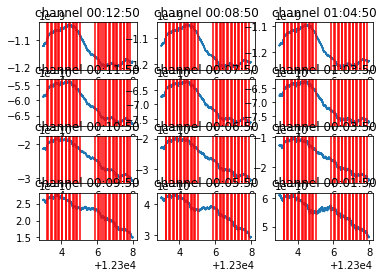

In [131]:
%matplotlib inline
## Plot time-series primary channels
raw_arr = raw[:][0]
print(raw_arr.shape)

start = 0
end = 5000

markers_line = adc_diode_markers[start:end].astype(bool)
marker_ts = time_stamps[start:end][markers_line]

plt.figure()
for i in range(raw_arr.shape[0]): 
    plt.subplot(4,3,i+1)
    plt.title('channel ' + raw.ch_names[i])
    plt.plot(time_stamps[start:end], raw_arr[i, start:end])
    adc_diode_markers
    for ts in marker_ts:
        # print(time_stamps[j])
        plt.axvline(x=ts, c="red")


## make epochs
# get the markers sent from pygame



## Analyze phase information of visual stimuli and OPM data

In [132]:
%matplotlib qt
def wrap(phases):
    return (phases + np.pi) % (2 * np.pi) - np.pi

def circ_detrend(phases): 
    # uses Euler's formula to get angle's vector, then get mean angle
    # complex_phase_diff = np.exp(np.complex(-1,1)*(phases))
    # plv = np.abs(np.sum(complex_phase_diff)/ len(phases))
    # plv= np.abs(np.sum(np.exp(1j*phases))) / len(phases)
    plv = (np.exp(1j*phases)).mean()
    mean = np.angle(plv)
    print(np.abs(plv))
    return wrap(phases-mean) 


# filter OPM data to the target frequency - 10Hz, or not? 
raw.filter(9,11)
raw_arr = raw[:][0]

plt.figure()
## for each channel
for i in range(raw_arr.shape[0]): 

    opm_angle = np.angle(hilbert(raw_arr[i]), deg=False)
    data = wrap(opm_angle-adc_diode_phase)

    plt.subplot(4,3,i+1, polar=True)
    plt.title('channel ' + raw.ch_names[i])    
    # ax.get_yaxis().set_visible(False)
    plt.hist(circ_detrend(data),density=True,edgecolor='black')




Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

0.06819971019836632
0.026318760283172263
0.04566535181447662
0.06462052903485954
0.03981005923019883
0.06918809169814541
0.0811250682703178
0.07872598632264341
0.057866526235304874
0.11184708976558308
0.09665682035350091
0.053024008688838595
